In [ ]:
!pip install yahoo_fin
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 3.0 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=7b65db70f5ed23a5697be4650eb4af9b1ba3a3896bfda958e745aa4edb857f26
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=b65f248f3ea80c398c392baee35275980f86ac96513916b00f7c5d94e5631702
  Stored in directory: /root/.cache/pip/wheels/70/4b/f0/ea

In [ ]:
# Import required libraries
from yahoofinancials import YahooFinancials
import yahoo_fin.stock_info as si
import yfinance as yf
import pandas as pd
import numpy as np
from yahoo_fin import news
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
import pytz

# Ignoring ununnecessary warnings
import warnings
warnings.filterwarnings("ignore")

# Importing library to split the data into training part and testing part.
from sklearn.model_selection import train_test_split

# Importing necessary libraries used for data cleaning, and data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

# Importing Models (used for making prediction)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC                            # Support vector machine model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Importing library to process the data (Normalize the data)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Hyperparameter tuner and Cross Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold


# Importing metrics used for evaluation of our models
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from google.colab import drive,files
drive.mount('/content/drive')
location = '/content/drive/MyDrive/AI/Project/Data/'


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Mounted at /content/drive


In [ ]:
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
pd.set_option('display.max_columns',29)

In [ ]:
def find_sentiment(ticker):

  # initialize SentimentIntensityAnalyzer
  sia = SentimentIntensityAnalyzer()

  # define stock ticker symbol
  ticker_symbol = ticker

  # set date range for news articles
  end_date = datetime.now(pytz.utc)
  start_date = end_date - timedelta(days=1)

  # get news articles from Yahoo Finance RSS feed
  articles = news.get_yf_rss(ticker_symbol)

  # filter articles based on publication date
  filtered_articles = [article for article in articles if start_date <= datetime.strptime(article["published"], "%a, %d %b %Y %H:%M:%S %z").replace(tzinfo=pytz.utc) <= end_date]

#  print(filtered_articles)

  # create empty list to store article sentiment scores
  scores = []

  # loop through each article and calculate sentiment score
  for article in filtered_articles:
      # extract article link
      link = article["link"]

      # request content from link
      response = requests.get(link)
      soup = BeautifulSoup(response.content, "html.parser")

      # extract article content from link
      content = ""
      for paragraph in soup.find_all("p"):
          content += paragraph.text

      # calculate sentiment score
      score = sia.polarity_scores(content)
      scores.append(score)

#      print(content)

  # convert list of scores to pandas dataframe
  df = pd.DataFrame(scores)

  # classify each article as positive, negative or neutral
  if not df.empty:
      df["sentiment"] = df["compound"].apply(lambda x: "positive" if x > 0 else "negative" if x < 0 else "neutral")

      # count the number of articles for each sentiment category
      counts = df["sentiment"].value_counts()

      # find the sentiment with the highest count
      overall_sentiment = counts.idxmax()
  else:
      overall_sentiment = "neutral"

  #print(overall_sentiment)
  return overall_sentiment

In [ ]:
# define a list of ticker symbols
tickers = ['AAPL','GOOG','BLK','META','NKE','ZM','NFLX','DIS','IBM','AMD','EA','TSLA','MSFT','DFS','V','INTC','PAYX','TROW','PFG','CHRW','FIZZ','PSEC','LILA','GGAL','MOR']
#tickers = ['AAPL','GOOG']

# create an empty dataframe to store the data
data = pd.DataFrame()

yahoo_financials = YahooFinancials(tickers)
# loop through each ticker symbol and retrieve the data
for ticker in tickers:

  # create a pandas dataframe with the data for this ticker
  ticker_data = pd.DataFrame({
      "name": [ticker],
      #"Latest Closing Price": [latest_price],
      "price_to_earnings": [yahoo_financials.get_pe_ratio()[ticker]], # Price to Earnings
      "debt_to_equity": [yahoo_financials.get_financial_data()[ticker].get('debtToEquity', None)], # Debt to Equity
      "book_value_per_share": [yahoo_financials.get_key_statistics_data()[ticker].get('bookValue', None)], # Book Value Per Share
      "price_to_book_value" : [yahoo_financials.get_key_statistics_data()[ticker].get('priceToBook', None)], # Price to Book Value
      "52_week_high" : [yahoo_financials.get_yearly_high()[ticker]],
      "52_week_low" : [yahoo_financials.get_yearly_low()[ticker]],
      "50_day_moving_avg" : [yahoo_financials.get_50day_moving_avg()[ticker]],
      "200_day_moving_avg" : [yahoo_financials.get_200day_moving_avg()[ticker]],
      "sentiment": [find_sentiment(ticker)],
      "recommendation": [yahoo_financials.get_financial_data()[ticker].get('recommendationKey', None)] # Recommendation
  })

  # append the data for this ticker to the main dataframe
  data = pd.concat([data, ticker_data], ignore_index=True)

In [ ]:
# create the csv file and store in drive
fn = location + 'data3.csv'
data.to_csv(fn,encoding = "UTF-8")

In [ ]:
df = pd.read_csv(location + 'data3.csv')
df

,Unnamed: 0,name,price_to_earnings,debt_to_equity,book_value_per_share,price_to_book_value,52_week_high,52_week_low,50_day_moving_avg,200_day_moving_avg,sentiment,recommendation
0,0,AAPL,28.808150,195.868,3.58100,47.383408,176.15,124.17,157.9030,150.896260,positive,buy
1,1,GOOG,23.223177,NaN,19.93500,5.428643,123.26,83.45,100.4502,101.224530,positive,strong_buy
2,2,BLK,20.793062,21.887,252.03600,2.663112,785.65,503.12,668.5212,677.571100,neutral,buy
3,3,META,29.596060,NaN,48.09200,4.997089,241.69,88.09,199.2596,155.629300,positive,buy
4,4,NKE,36.518730,86.477,9.43600,13.429419,131.31,82.22,121.7076,111.896950,positive,buy
5,5,ZM,180.676470,1.554,21.12400,2.908066,124.05,60.45,69.7298,78.616974,neutral,hold
6,6,NFLX,34.475445,77.679,49.10300,6.719141,379.43,162.71,323.7602,286.457240,positive,buy
7,7,DIS,54.812836,44.432,52.65600,1.946597,126.48,84.07,98.5074,101.282850,positive,buy
8,8,IBM,56.433037,284.588,23.80600,5.310006,153.21,115.55,128.2272,133.525250,neutral,hold
9,9,AMD,103.918610,5.399,33.96400,2.631315,109.57,54.57,88.6682,78.825200,positive,buy


In [ ]:
# Checking the number of rows and columns in our dataset
df.shape

(25, 12)

In [ ]:
# Getting more information of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            25 non-null     int64  
 1   name                  25 non-null     object 
 2   price_to_earnings     23 non-null     float64
 3   debt_to_equity        17 non-null     float64
 4   book_value_per_share  25 non-null     float64
 5   price_to_book_value   25 non-null     float64
 6   52_week_high          25 non-null     float64
 7   52_week_low           25 non-null     float64
 8   50_day_moving_avg     25 non-null     float64
 9   200_day_moving_avg    25 non-null     float64
 10  sentiment             25 non-null     object 
 11  recommendation        25 non-null     object 
dtypes: float64(8), int64(1), object(3)
memory usage: 2.5+ KB


In [ ]:
df.isnull().sum()

# Observations: Seems there are some null values. We will remove it but before removing we will check null values by another technique. Also dtype of many columns are wrong.

Unnamed: 0              0
name                    0
price_to_earnings       2
debt_to_equity          8
book_value_per_share    0
price_to_book_value     0
52_week_high            0
52_week_low             0
50_day_moving_avg       0
200_day_moving_avg      0
sentiment               0
recommendation          0
dtype: int64

In [ ]:
# Getting some statistical information of our data
df.describe()

# Observations: Count of each column is different which indicates presence of null values. We already seen that there is null values in our dataset

,Unnamed: 0,price_to_earnings,debt_to_equity,book_value_per_share,price_to_book_value,52_week_high,52_week_low,50_day_moving_avg,200_day_moving_avg
count,25.000000,23.000000,17.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,12.000000,40.336887,89.539000,197.287350,7.397498,164.516400,98.970800,134.770472,132.056631
std,7.359801,38.659766,104.235994,821.158589,9.530811,161.811833,99.517055,137.537898,135.849998
min,0.000000,3.962334,1.554000,1.151750,0.002788,6.150000,3.170000,4.466800,4.683225
25%,6.000000,18.791897,12.041000,9.945000,1.946597,96.170000,54.570000,69.729800,78.616974
50%,12.000000,31.155289,44.432000,22.313000,4.637639,126.480000,86.600000,102.760600,102.940350
75%,18.000000,41.867123,126.881000,41.075000,10.835531,176.150000,108.530000,157.903000,150.896260
max,24.000000,180.676470,328.370000,4132.010000,47.383408,785.650000,503.120000,668.521200,677.571100


In [ ]:
# Distribution of our target variable i.e. "rec" column
df["recommendation"].value_counts()

buy             13
hold            10
strong_buy       1
underperform     1
Name: recommendation, dtype: int64

In [ ]:
for i in df.columns:
    print('Unique Values in "{}":\n'.format(i),df[i].unique(), "\n\n")

Unique Values in "Unnamed: 0":
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] 


Unique Values in "name":
 ['AAPL' 'GOOG' 'BLK' 'META' 'NKE' 'ZM' 'NFLX' 'DIS' 'IBM' 'AMD' 'EA'
 'TSLA' 'MSFT' 'DFS' 'V' 'INTC' 'PAYX' 'TROW' 'PFG' 'CHRW' 'FIZZ' 'PSEC'
 'LILA' 'GGAL' 'MOR'] 


Unique Values in "price_to_earnings":
 [ 28.80815    23.223177   20.793062   29.59606    36.51873   180.67647
  34.475445   54.812836   56.433037  103.91861    34.399998   47.215515
  33.32538     6.962988   31.155289   16.01031    26.472288   16.790733
   3.9623342  15.985738   33.355705   85.125             nan   7.731544 ] 


Unique Values in "debt_to_equity":
 [195.868     nan  21.887  86.477   1.554  77.679  44.432 284.588   5.399
  29.771  11.321 126.881  25.615   4.466  12.041  50.161 328.37  215.653] 


Unique Values in "book_value_per_share":
 [3.58100e+00 1.99350e+01 2.52036e+02 4.80920e+01 9.43600e+00 2.11240e+01
 4.91030e+01 5.26560e+01 2.38060e+01 3.39640e+01 2.74450e+01 1

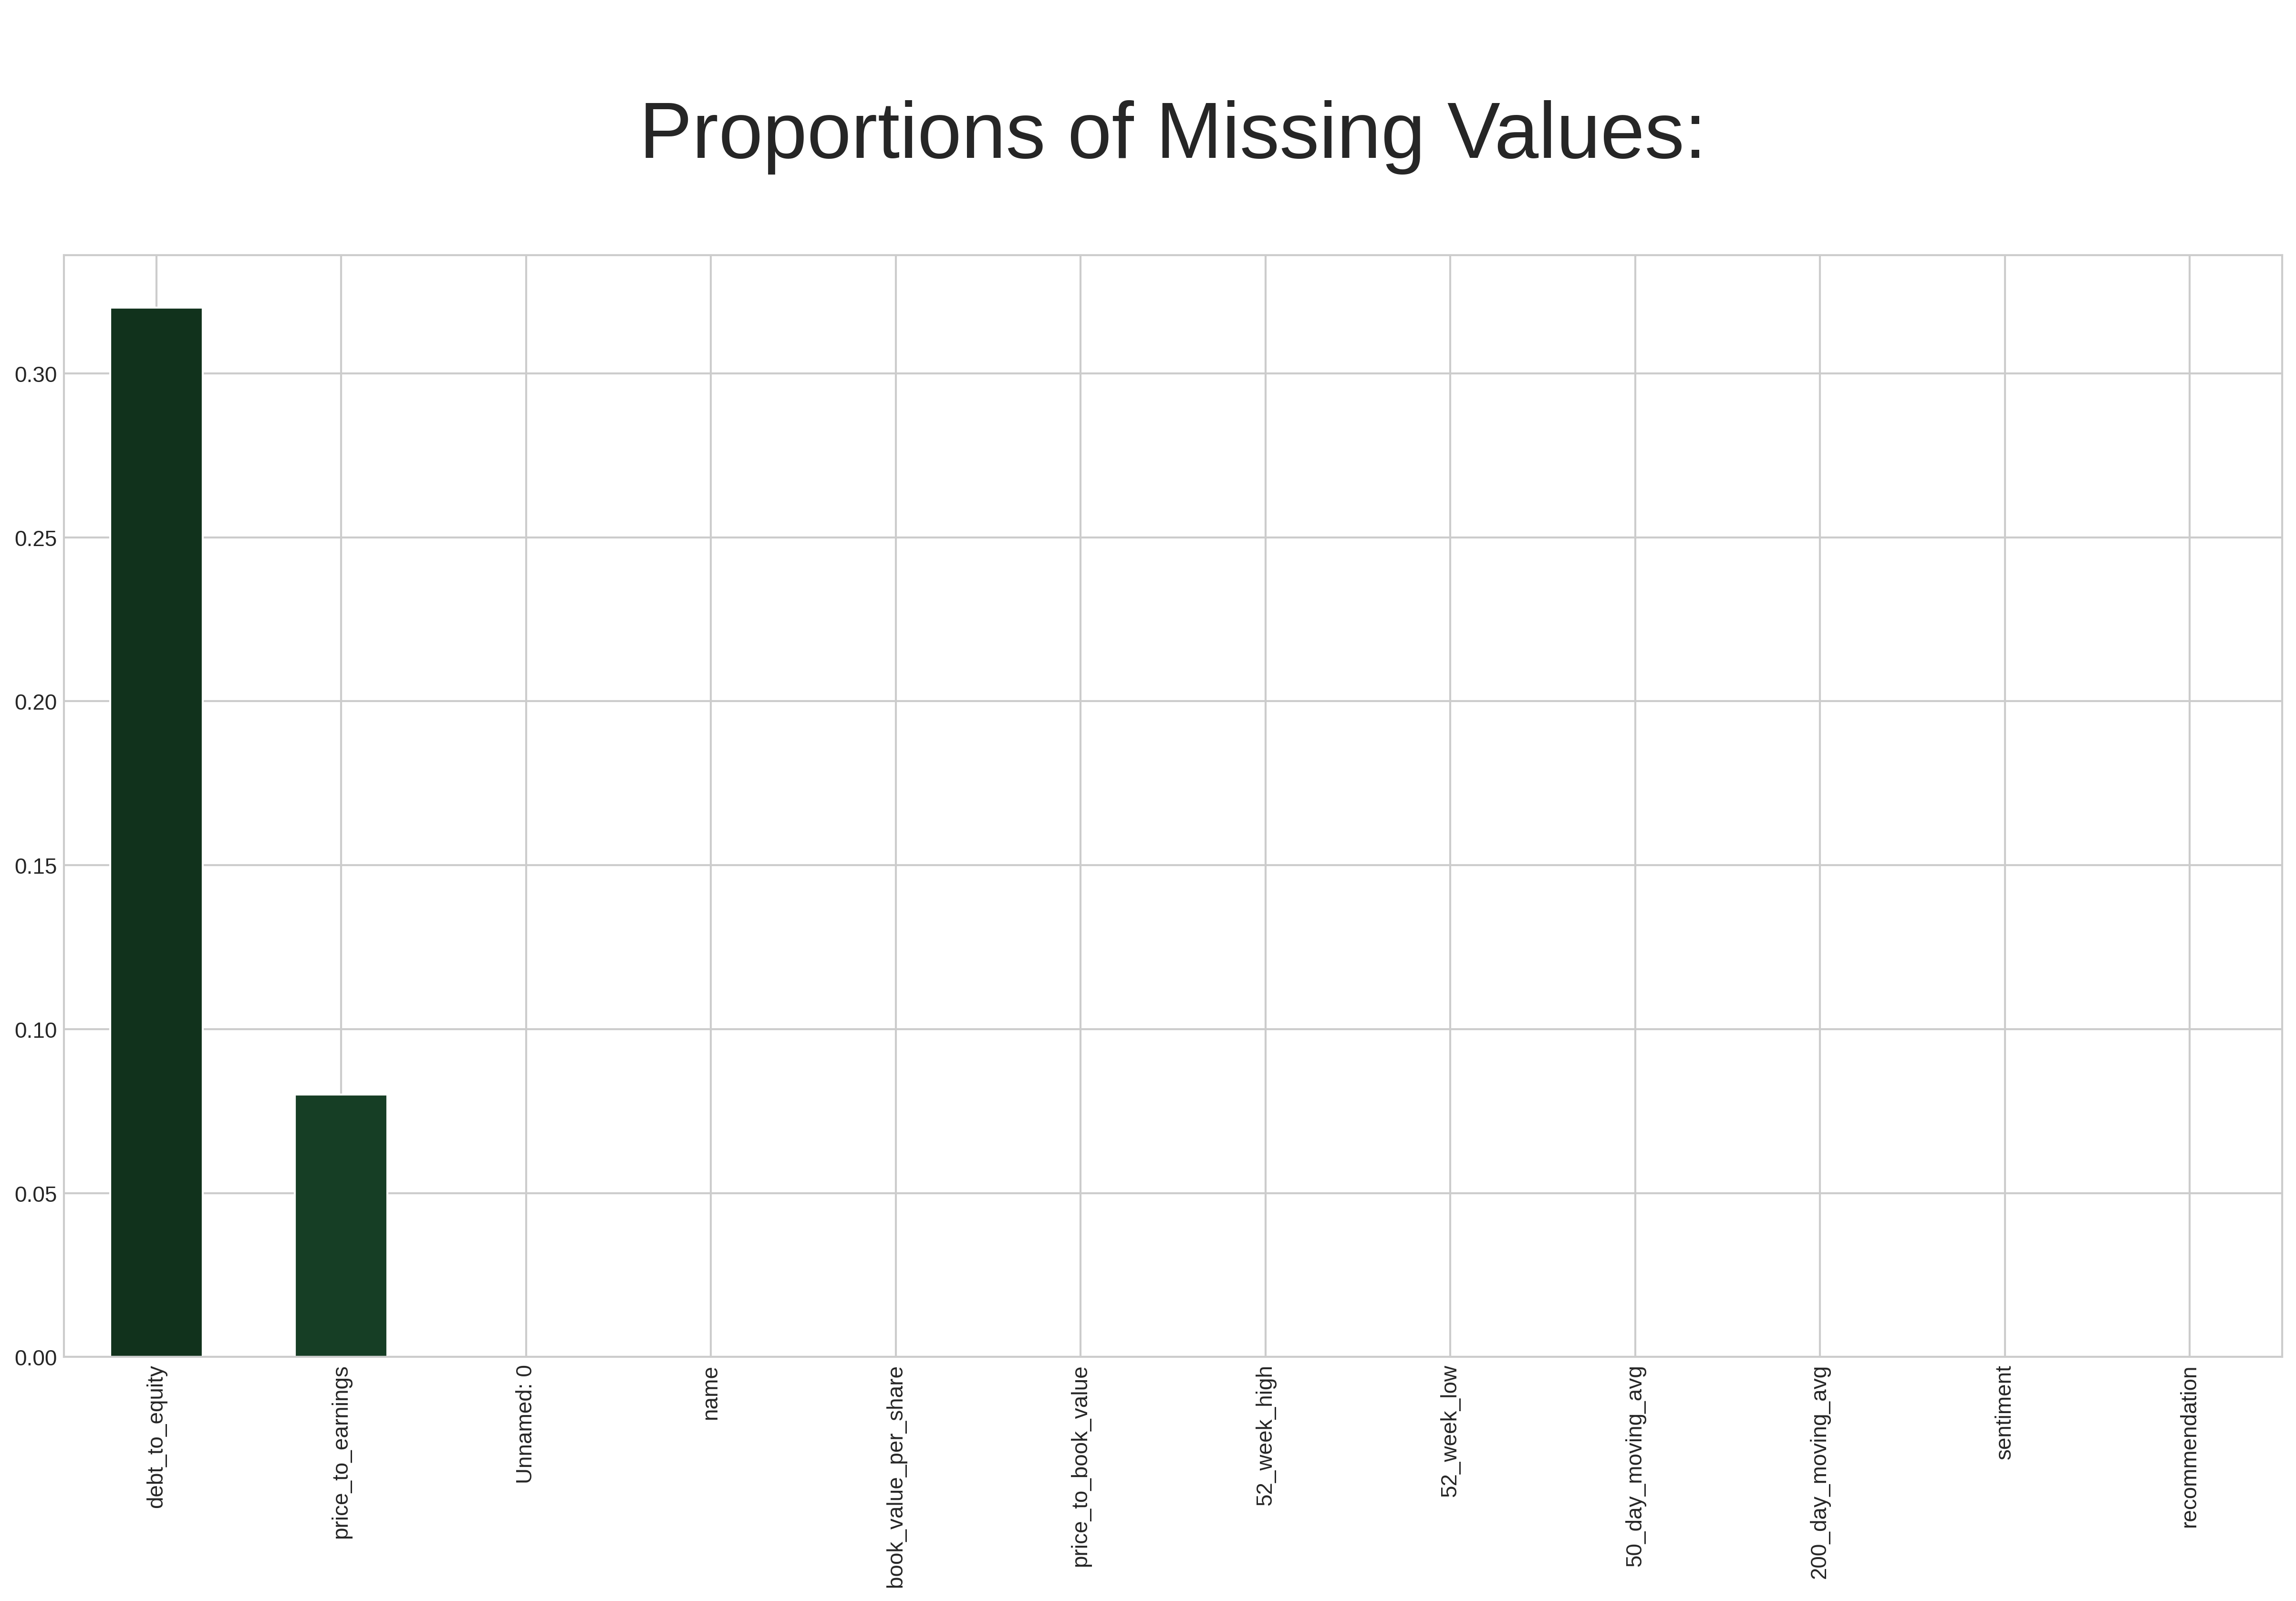

In [ ]:
 # Check null values in form of a graph first
plt.style.use("seaborn-v0_8-whitegrid")

d = ((df.isnull().sum()/df.shape[0])).sort_values(ascending=False)
# Here we are plotting null values in range of 0-1. It means y axis range is 0-1.
# If bar graph show 0.5 null values that means there are 50% null values in that particular column.
# Hence we are dividing number of null values of each column with total number of rows i.e. 400 (or df.shape[0])

d.plot(kind = 'bar',
       color = sns.cubehelix_palette(start=2,
                                    rot=0.15,
                                    dark=0.15,
                                    light=0.95,
                                    reverse=True,
                                    n_colors=24),
        figsize=(20,10))
plt.title("\nProportions of Missing Values:\n",fontsize=40)
plt.show()

<Axes: xlabel='200_day_moving_avg', ylabel='Count'>

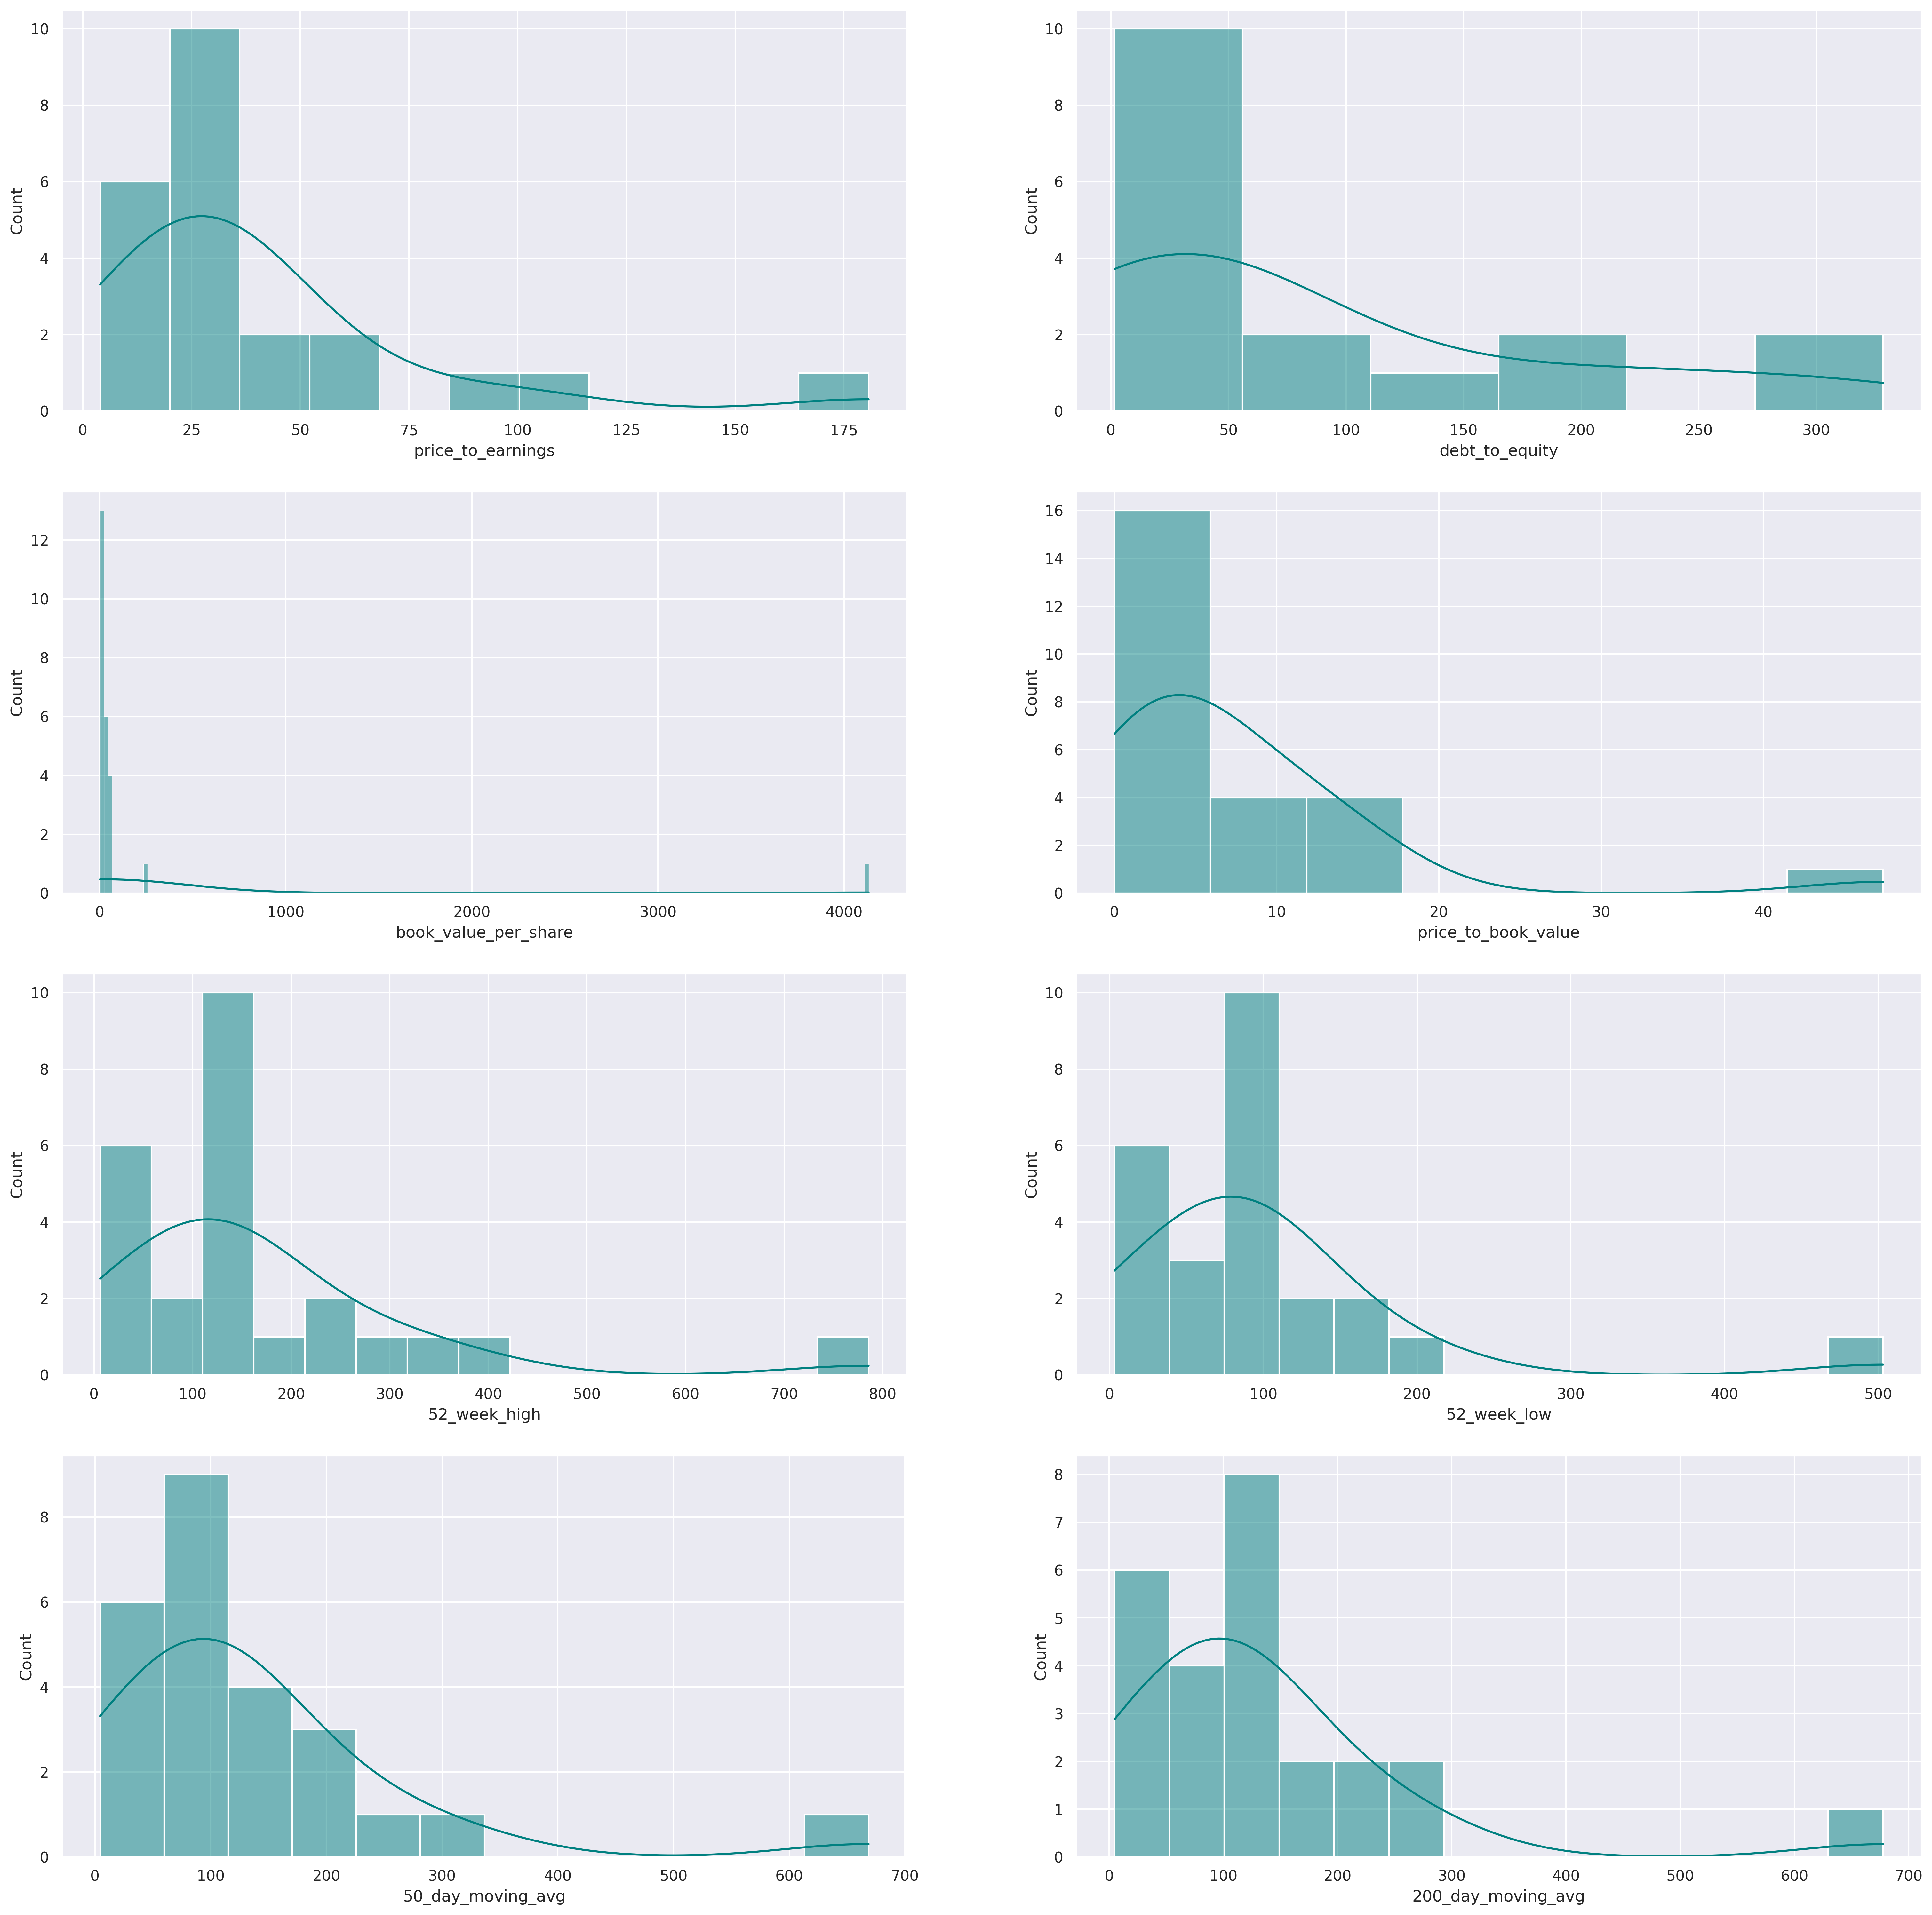

In [ ]:
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above)

sns.set(style="darkgrid")
fig, axs = plt.subplots(4, 2, figsize=(25, 25))

sns.histplot(df["price_to_earnings"], kde=True, color="teal", ax=axs[0, 0])
sns.histplot(df["debt_to_equity"], kde=True, color="teal", ax=axs[0, 1])
sns.histplot(df["book_value_per_share"], kde=True, color="teal", ax=axs[1, 0])
sns.histplot(df["price_to_book_value"], kde=True, color="teal", ax=axs[1, 1])
sns.histplot(df["52_week_high"], kde=True, color="teal", ax=axs[2, 0])
sns.histplot(df["52_week_low"], kde=True, color="teal", ax=axs[2, 1])
sns.histplot(df["50_day_moving_avg"], kde=True, color="teal", ax=axs[3, 0])
sns.histplot(df["200_day_moving_avg"], kde=True, color="teal", ax=axs[3, 1])

In [ ]:
# Will replace null values with median for numeric attribute

df["price_to_earnings"] = df["price_to_earnings"].replace(np.NaN, df["price_to_earnings"].median())
df["debt_to_equity"] = df["debt_to_equity"].replace(np.NaN, df["debt_to_equity"].median())
df["book_value_per_share"] = df["book_value_per_share"].replace(np.NaN, df["book_value_per_share"].median())
df["price_to_book_value"] = df["price_to_book_value"].replace(np.NaN, df["price_to_book_value"].median())
df["52_week_high"] = df["52_week_high"].replace(np.NaN, df["52_week_high"].median())
df["52_week_low"] = df["52_week_low"].replace(np.NaN, df["52_week_low"].median())
df["50_day_moving_avg"] = df["50_day_moving_avg"].replace(np.NaN, df["50_day_moving_avg"].median())
df["200_day_moving_avg"] = df["200_day_moving_avg"].replace(np.NaN, df["200_day_moving_avg"].median())


# Will replace the null value with "Hold" in recommendation column

df["recommendation"] = df["recommendation"].replace(np.NaN, "hold")

# Will replace the strong_buy with "Buy" in recommendation column

df["recommendation"] = df["recommendation"].replace("strong_buy", "buy")

# Will replace the underperform with "Sell" in recommendation column

df["recommendation"] = df["recommendation"].replace("underperform", "sell")


In [ ]:
# Handling Data Types

df[['price_to_earnings', 'debt_to_equity', 'book_value_per_share','price_to_book_value','52_week_high','52_week_low','50_day_moving_avg','200_day_moving_avg']] = df[['price_to_earnings', 'debt_to_equity', 'book_value_per_share','price_to_book_value','52_week_high','52_week_low','50_day_moving_avg','200_day_moving_avg']].astype('float64')
df.dtypes

Unnamed: 0                int64
name                     object
price_to_earnings       float64
debt_to_equity          float64
book_value_per_share    float64
price_to_book_value     float64
52_week_high            float64
52_week_low             float64
50_day_moving_avg       float64
200_day_moving_avg      float64
sentiment                object
recommendation           object
dtype: object

In [ ]:
# Dropping unnecessary columns

df.drop(columns=df.columns[0], axis=1, inplace=True)

<Axes: xlabel='recommendation', ylabel='count'>

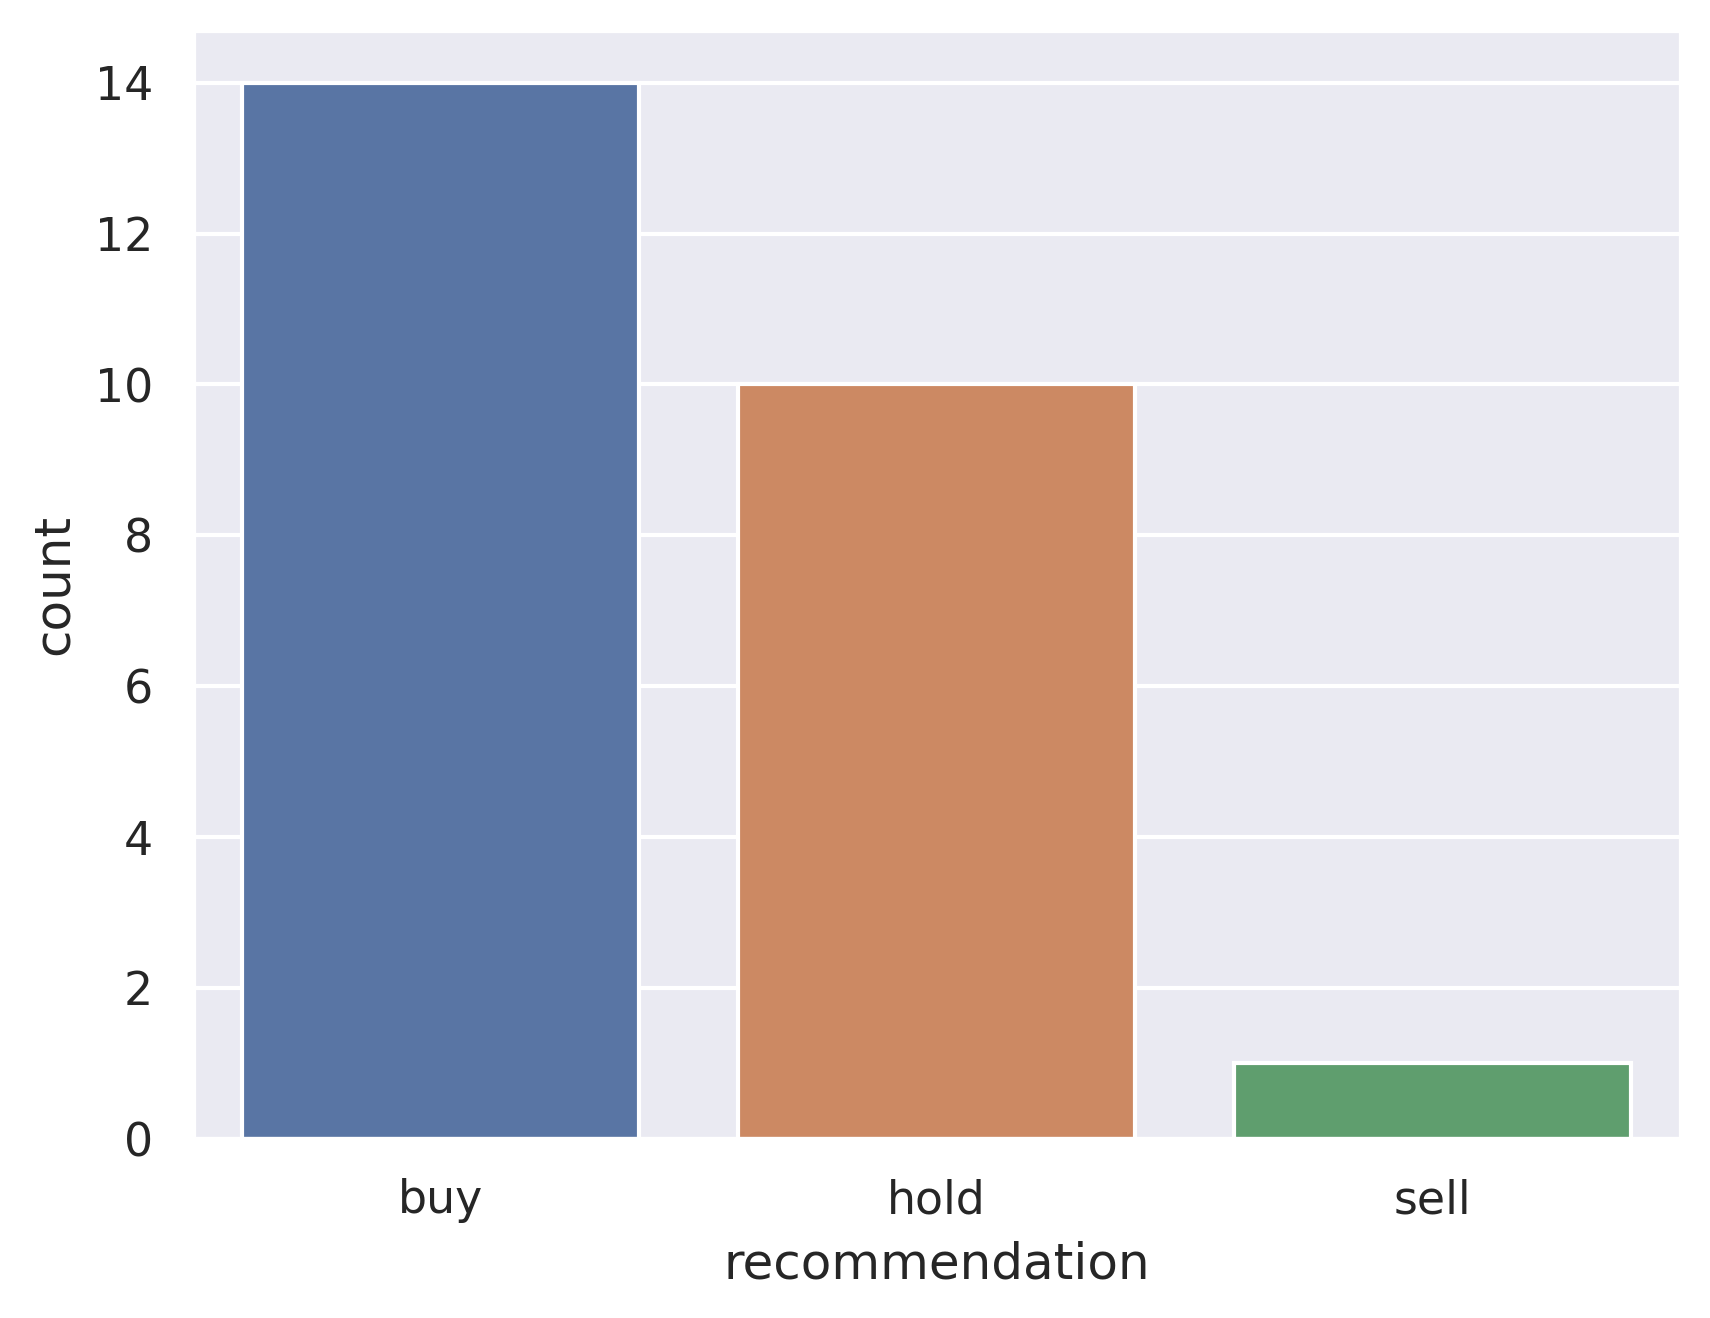

In [ ]:
# Data Visualization

sns.countplot(x = "recommendation", data = df)

<Axes: title={'center': 'Stock Sentiment Attributes Correlation'}>

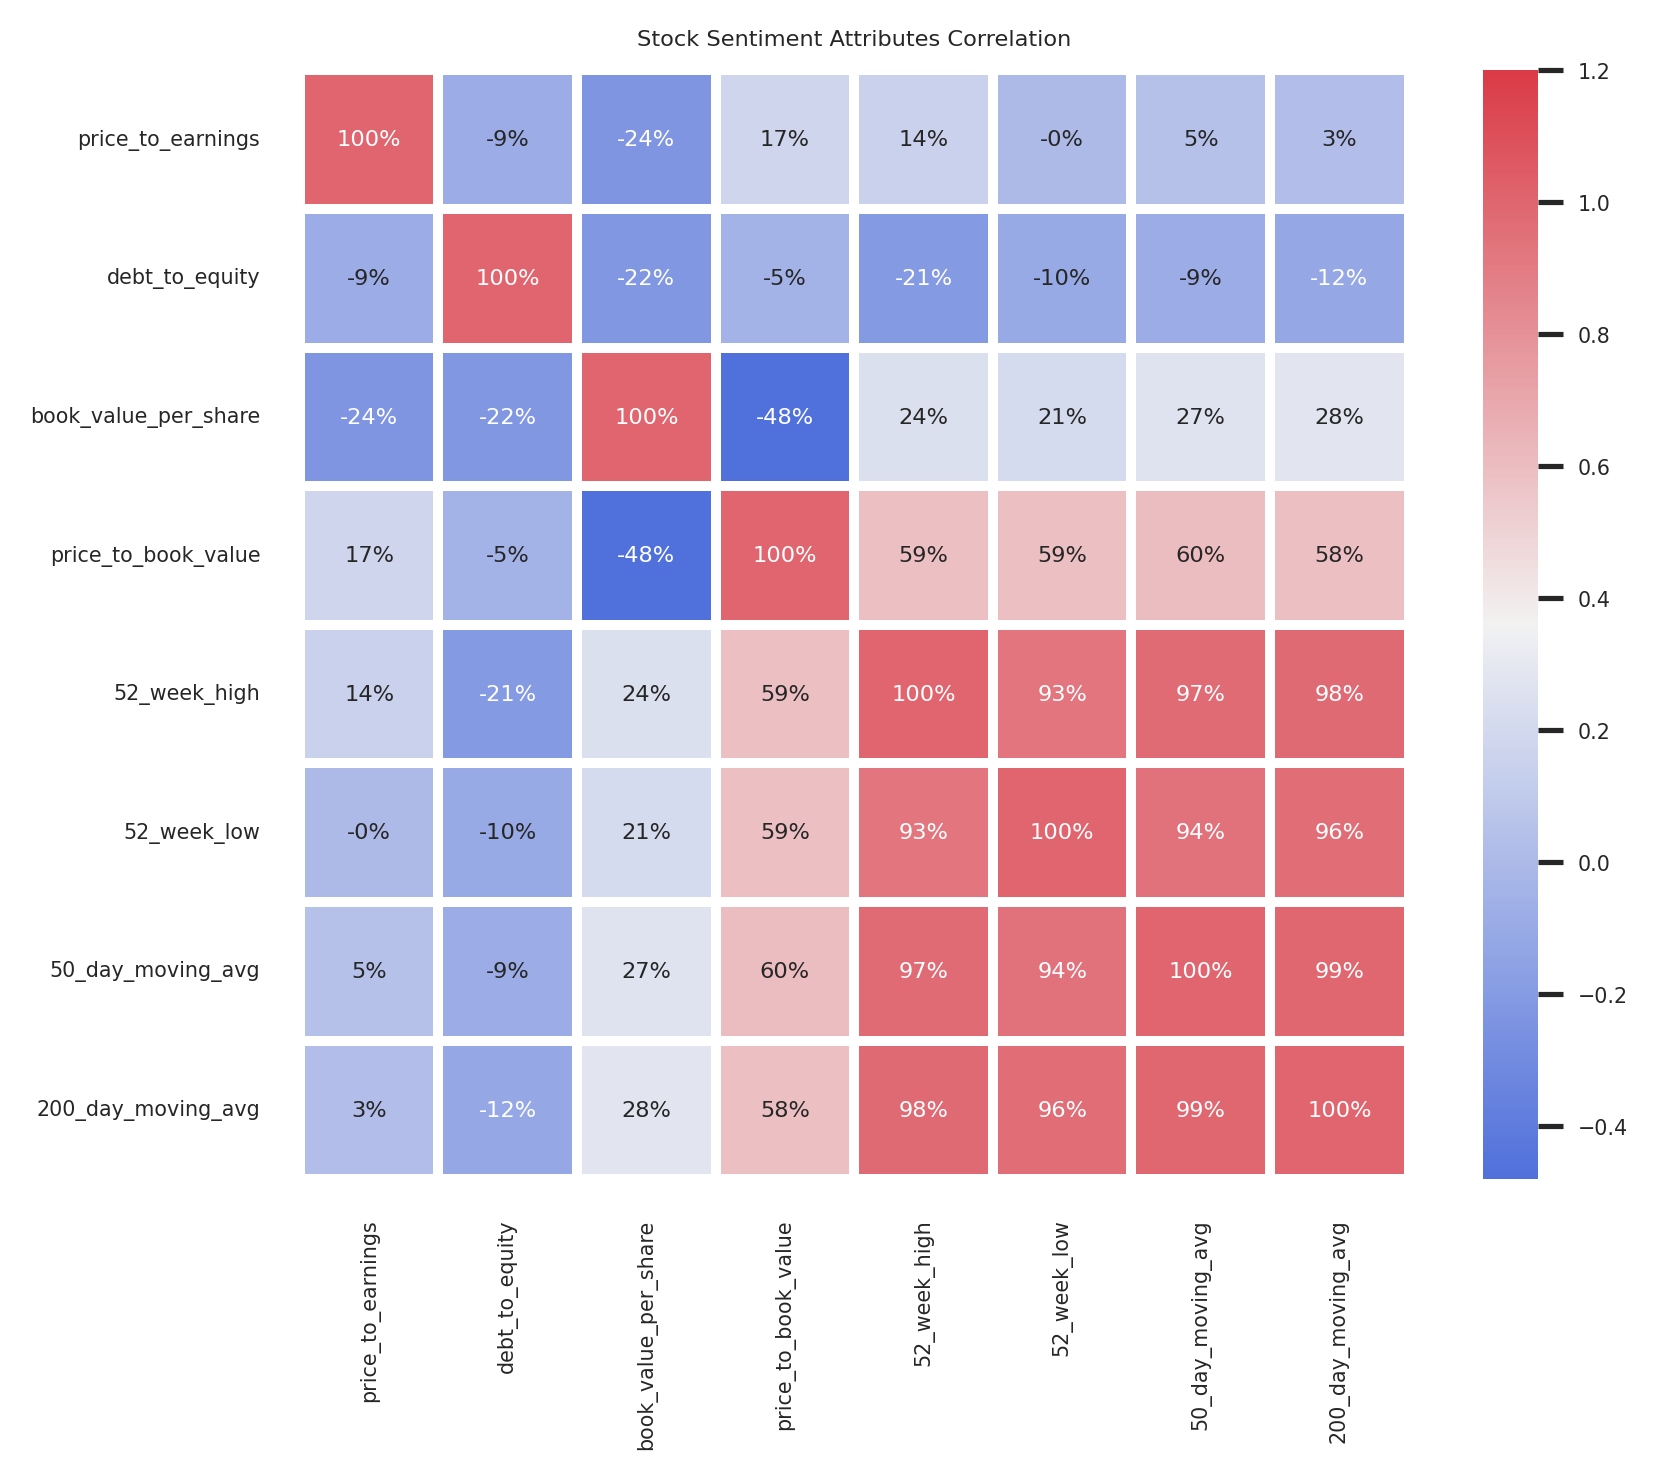

In [ ]:
# Correlation Metrix

sns.set(font_scale=0.45)
plt.title('Stock Sentiment Attributes Correlation')
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(df[["price_to_earnings","debt_to_equity","book_value_per_share","price_to_book_value",'52_week_high','52_week_low','50_day_moving_avg','200_day_moving_avg','sentiment']].corr("spearman"), vmax=1.2, annot=True, square='square', cmap=cmap, fmt = '.0%', linewidths=2)

In [ ]:
# Label encoding

df[['recommendation']] = df[['recommendation']].replace(to_replace={'buy':1, 'sell':0, 'hold':2})
df[['recommendation']] = df[['recommendation']].astype('int64')

df[['sentiment']] = df[['sentiment']].replace(to_replace={'positive':1, 'negative':0, 'neutral':2})
df[['sentiment']] = df[['sentiment']].astype('int64')


df.dtypes

name                     object
price_to_earnings       float64
debt_to_equity          float64
book_value_per_share    float64
price_to_book_value     float64
52_week_high            float64
52_week_low             float64
50_day_moving_avg       float64
200_day_moving_avg      float64
sentiment                 int64
recommendation            int64
dtype: object

In [ ]:
df

,name,price_to_earnings,debt_to_equity,book_value_per_share,price_to_book_value,52_week_high,52_week_low,50_day_moving_avg,200_day_moving_avg,sentiment,recommendation
0,AAPL,28.808150,195.868,3.58100,47.383408,176.15,124.17,157.9030,150.896260,1,1
1,GOOG,23.223177,44.432,19.93500,5.428643,123.26,83.45,100.4502,101.224530,1,1
2,BLK,20.793062,21.887,252.03600,2.663112,785.65,503.12,668.5212,677.571100,2,1
3,META,29.596060,44.432,48.09200,4.997089,241.69,88.09,199.2596,155.629300,1,1
4,NKE,36.518730,86.477,9.43600,13.429419,131.31,82.22,121.7076,111.896950,1,1
5,ZM,180.676470,1.554,21.12400,2.908066,124.05,60.45,69.7298,78.616974,2,2
6,NFLX,34.475445,77.679,49.10300,6.719141,379.43,162.71,323.7602,286.457240,1,1
7,DIS,54.812836,44.432,52.65600,1.946597,126.48,84.07,98.5074,101.282850,1,1
8,IBM,56.433037,284.588,23.80600,5.310006,153.21,115.55,128.2272,133.525250,2,2
9,AMD,103.918610,5.399,33.96400,2.631315,109.57,54.57,88.6682,78.825200,1,1


In [ ]:
# Seperating target

X = df.drop(["recommendation","name"], axis=1)
y = df["recommendation"]

In [ ]:
# Standardization of the data which will help in increasing the performance of the model and increasing accuracy.

scaler = StandardScaler()
features = scaler.fit_transform(X)
features


array([[-0.29693971,  1.40418298, -0.24075826,  4.28194935,  0.0733784 ,
         0.25843636,  0.17165841,  0.14153932, -1.22474487],
       [-0.45057767, -0.35664965, -0.22043182, -0.21083771, -0.26022285,
        -0.15917724, -0.25467876, -0.23163696, -1.22474487],
       [-0.51742811, -0.61879321,  0.06804728, -0.50698865,  3.91777173,
         4.14484784,  3.96077783,  4.09836865,  0.81649658],
       [-0.27526496, -0.35664965, -0.18543539, -0.25705125,  0.48676895,
        -0.11159062,  0.47855131,  0.17709794, -1.22474487],
       [-0.08482807,  0.13223151, -0.23348106,  0.64593709, -0.20944785,
        -0.1717918 , -0.09693501, -0.15145667, -1.22474487],
       [ 3.88083141, -0.85521658, -0.21895401, -0.48075731, -0.25523996,
        -0.39505919, -0.48264412, -0.40148415,  0.81649658],
       [-0.14103714,  0.02993215, -0.18417882, -0.07264285,  1.35555769,
         0.65369246,  1.4024268 ,  1.15998869, -1.22474487],
       [ 0.41842756, -0.35664965, -0.17976278, -0.58371768, -0

In [ ]:
# Splitting the data into train and test data

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

In [ ]:
len(y_train[y_train==1]), len(y_train[y_train==0]), y_train.shape

(12, 1, (20,))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()

X_train_down,y_train_down = rus.fit_resample(X_train, y_train)

print(len(y_train_down[y_train_down==0]), len(y_train_down[y_train_down==1]))
print(len(X_train_down))

1 1
3


In [ ]:
os =  RandomOverSampler()

X_train, y_train = os.fit_resample(X_train, y_train)

print(len(y_train[y_train==0]), len(y_train[y_train==1]))
print(len(X_train))

12 12
36


**Decision Tree Model**


In [ ]:
def dtree_grid_search(X, y):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(2, 15)}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # decision tree model
    dtree = DecisionTreeClassifier()

    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
    #fit model to data
    dtree_gscv.fit(X, y)

    return dtree_gscv.best_params_

In [ ]:
dtree_grid_search(X_train, y_train)

{'criterion': 'entropy', 'max_depth': 14}

In [ ]:
dTree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 11)
dTree.fit(X_train, y_train)

print(dTree.score(X_train,y_train))
print(dTree.score(X_test,y_test))

y_pred_dtree = dTree.predict(X_test)

print(metrics.classification_report(y_test, y_pred_dtree))

1.0
0.6
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.50      0.50         2
           2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.39      0.43         5
weighted avg       0.80      0.60      0.68         5



In [ ]:
dt_tacc = dTree.score(X_test,y_test)
dt_train_acc = dTree.score(X_train, y_train)

<Axes: >

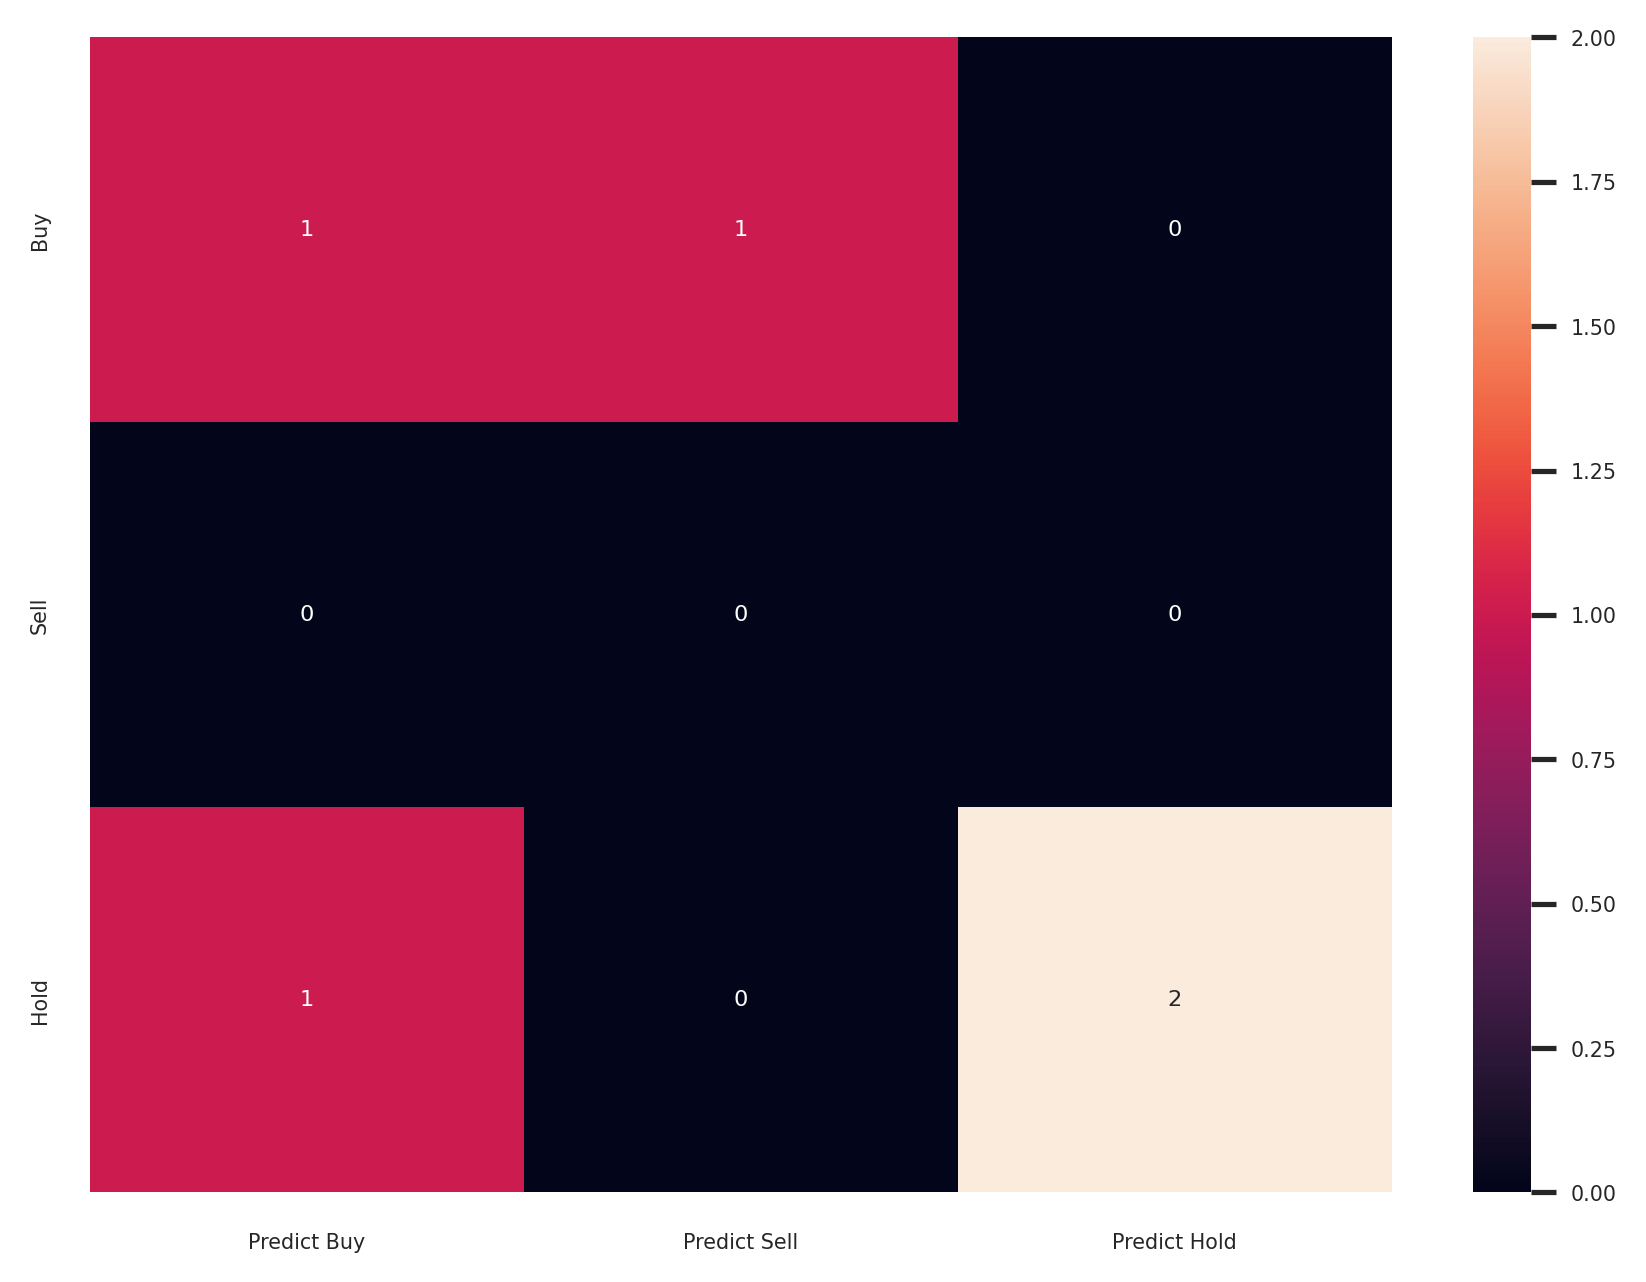

In [ ]:
# Confusion Matrix of Decision Tree Classifier

cm = metrics.confusion_matrix(y_test, y_pred_dtree, labels=[1,0,2])

df_cm = pd.DataFrame(cm, index = [i for i in ["Buy","Sell","Hold"]],
                         columns = [i for i in ["Predict Buy", "Predict Sell","Predict Hold"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# Find Performance of Decision Tree

y_pred_proba = dTree.predict(X_test)
dt_performance = accuracy_score(y_test, y_pred_proba)
dt_performance

0.6

**SVM**

In [ ]:
def svm_grid_search(X, y):
    #create a dictionary of all values we want to test
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001, 0.4, 0.2, 0.8],'kernel': ['rbf', 'poly', 'sigmoid']}
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    svm = SVC()

    #use gridsearch to test all values
    svm_gscv = RandomizedSearchCV(estimator = svm,
                           param_distributions = param_grid,
                           scoring = 'accuracy',
                           cv = cv,
                           n_jobs = -1)
    #fit model to data
    svm_gscv.fit(X, y)

    return svm_gscv.best_params_

In [ ]:
svm_grid_search(X_train, y_train)

{'kernel': 'rbf', 'gamma': 0.8, 'C': 1}

In [ ]:
from sklearn import svm
svm = SVC(gamma=0.8, C=10, kernel='rbf', probability=True)

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

print(metrics.classification_report(y_test, y_pred_svm))

1.0
0.6
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         2
           2       1.00      0.33      0.50         3

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5



In [ ]:
svm_tacc = svm.score(X_test, y_test)
svm_train_acc = svm.score(X_train, y_train)

<Axes: >

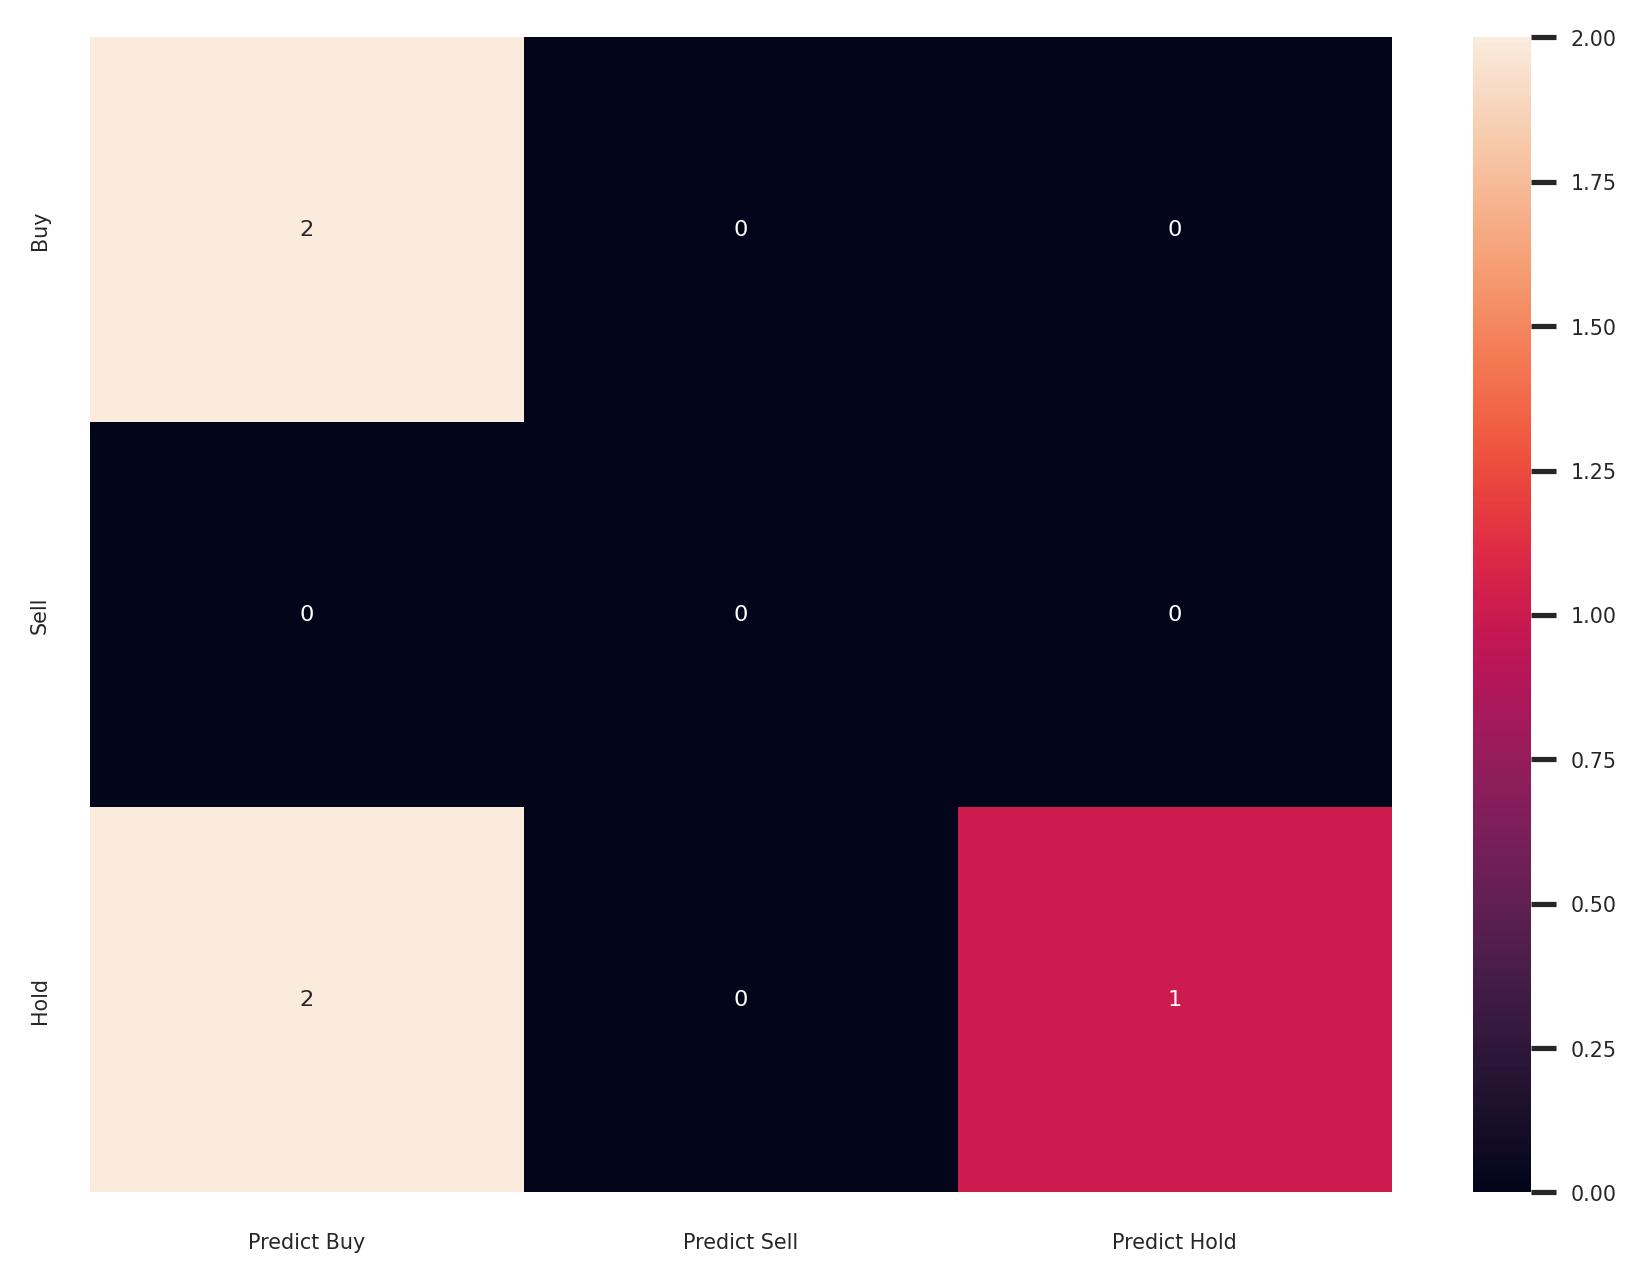

In [ ]:
# Confusion Matrix of SVM

cm = metrics.confusion_matrix(y_test, y_pred_svm, labels=[1,0,2])

df_cm = pd.DataFrame(cm, index = [i for i in ["Buy","Sell","Hold"]],
                         columns = [i for i in ["Predict Buy", "Predict Sell","Predict Hold"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# Find Performance of SVM

y_pred_proba = svm.predict(X_test)
svm_performance = accuracy_score(y_test, y_pred_proba)
svm_performance

0.6

**KNN**

In [ ]:
def knn_grid_search(X, y):
    #create a dictionary of all values we want to test
    k_range = list(range(1, 31))
    param_grid = dict(n_neighbors=k_range)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    knn = KNeighborsClassifier()

    #use gridsearch to test all values
    knn_gscv = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    #fit model to data
    knn_gscv.fit(X, y)

    return knn_gscv.best_params_

In [ ]:
knn_grid_search(X_train, y_train)

{'n_neighbors': 1}

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

print(metrics.classification_report(y_test, y_pred_knn))

1.0
0.8
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [ ]:
knn_tacc = knn.score(X_test, y_test)
knn_train_acc = knn.score(X_train, y_train)

<Axes: >

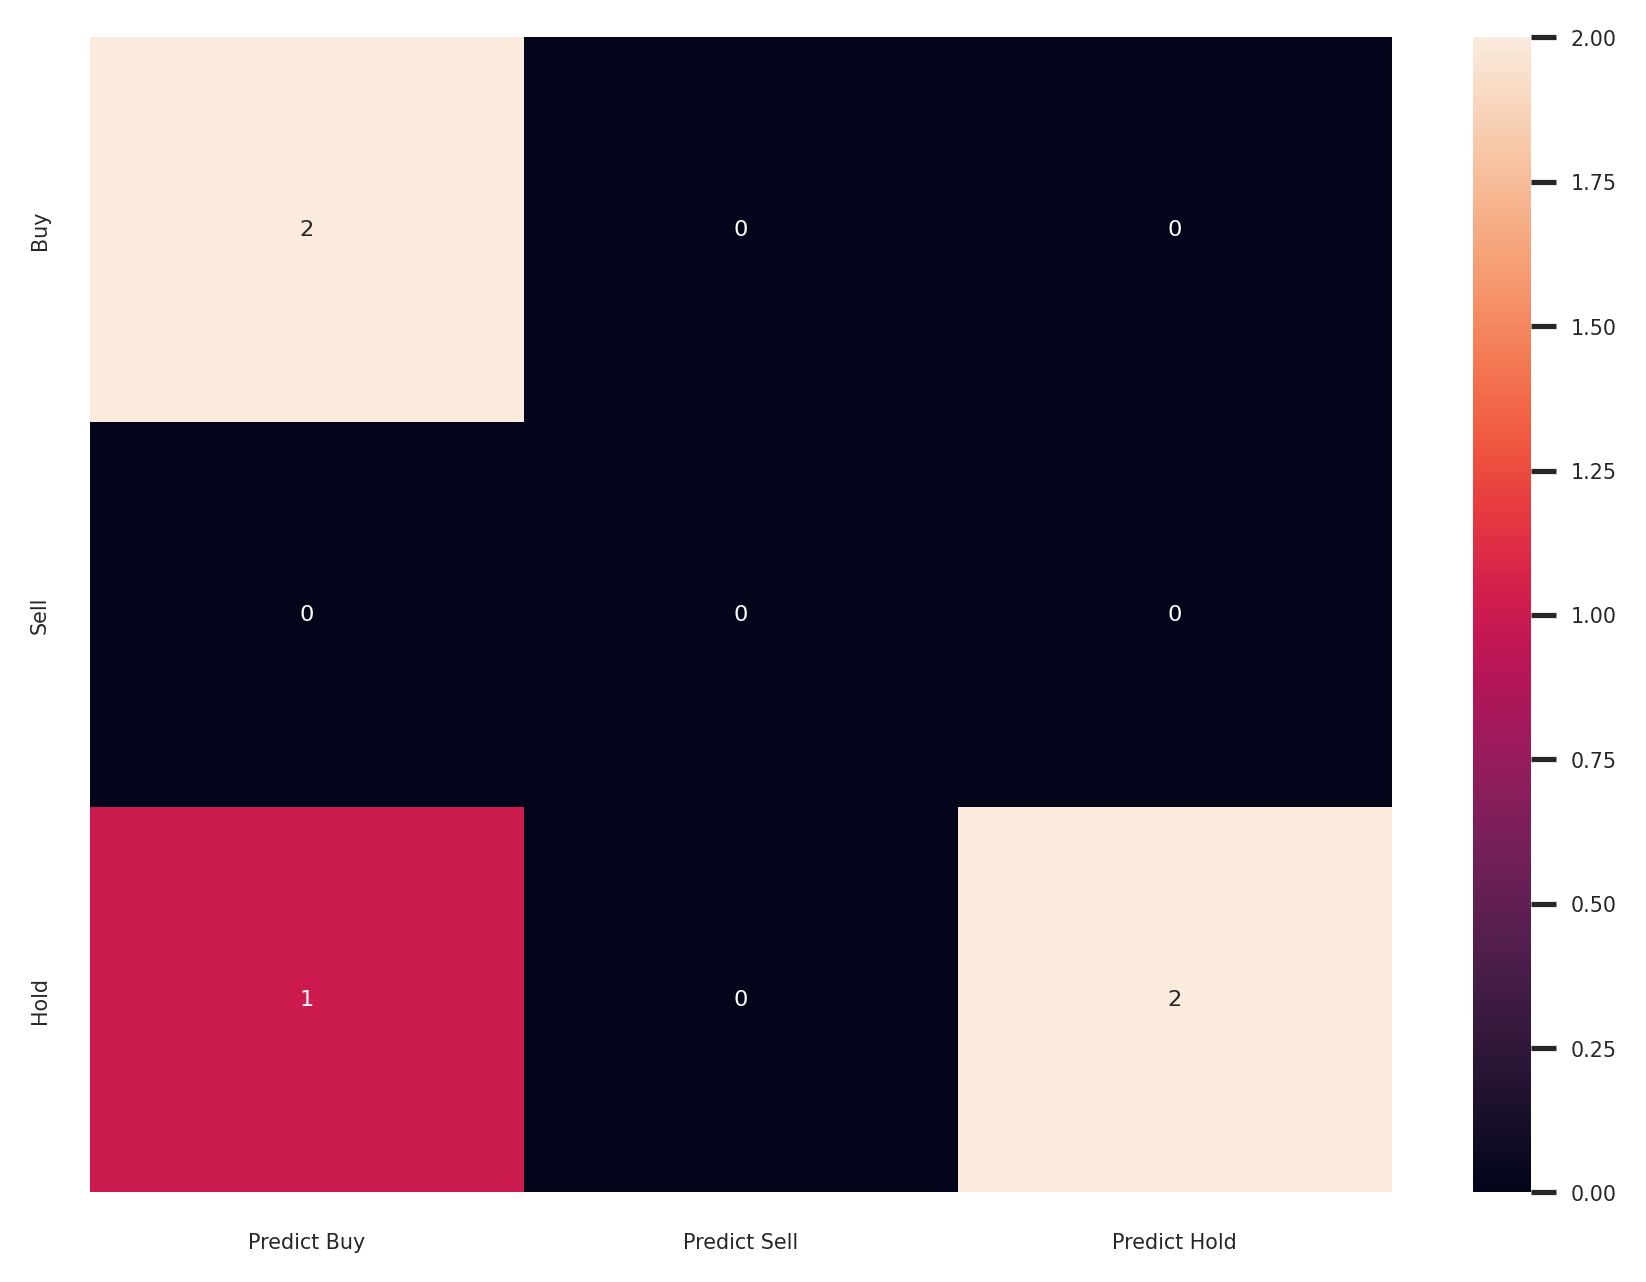

In [ ]:
# Confusion Matrix of KNN

cm = metrics.confusion_matrix(y_test, y_pred_knn, labels=[1,0,2])

df_cm = pd.DataFrame(cm, index = [i for i in ["Buy","Sell","Hold"]],
                         columns = [i for i in ["Predict Buy", "Predict Sell","Predict Hold"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# Find Performance of KNN

y_pred_proba = knn.predict(X_test)
knn_performance = accuracy_score(y_test, y_pred_proba)
knn_performance

0.8

**GaussianNB**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

def gnb_grid_search(X, y):
    # create a dictionary of all values we want to test
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

    gnb = GaussianNB()

    # use gridsearch to test all values
    gnb_gscv = GridSearchCV(estimator=gnb,
                            param_grid=param_grid,
                            scoring='accuracy',
                            cv=5,
                            n_jobs=-1)

    # fit model to data
    gnb_gscv.fit(X, y)

    return gnb_gscv.best_params_


In [ ]:
gnb_grid_search(X_train, y_train)

{'var_smoothing': 1e-09}

In [ ]:
gnb = GaussianNB(var_smoothing=1e-09)

gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)

print(gnb.score(X_train, y_train))
print(gnb.score(X_test, y_test))

print(metrics.classification_report(y_test, y_pred_gnb))

0.8611111111111112
0.4
              precision    recall  f1-score   support

           1       0.40      1.00      0.57         2
           2       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



In [ ]:
gnb_tacc = gnb.score(X_test, y_test)
gnb_train_acc = gnb.score(X_train, y_train)

<Axes: >

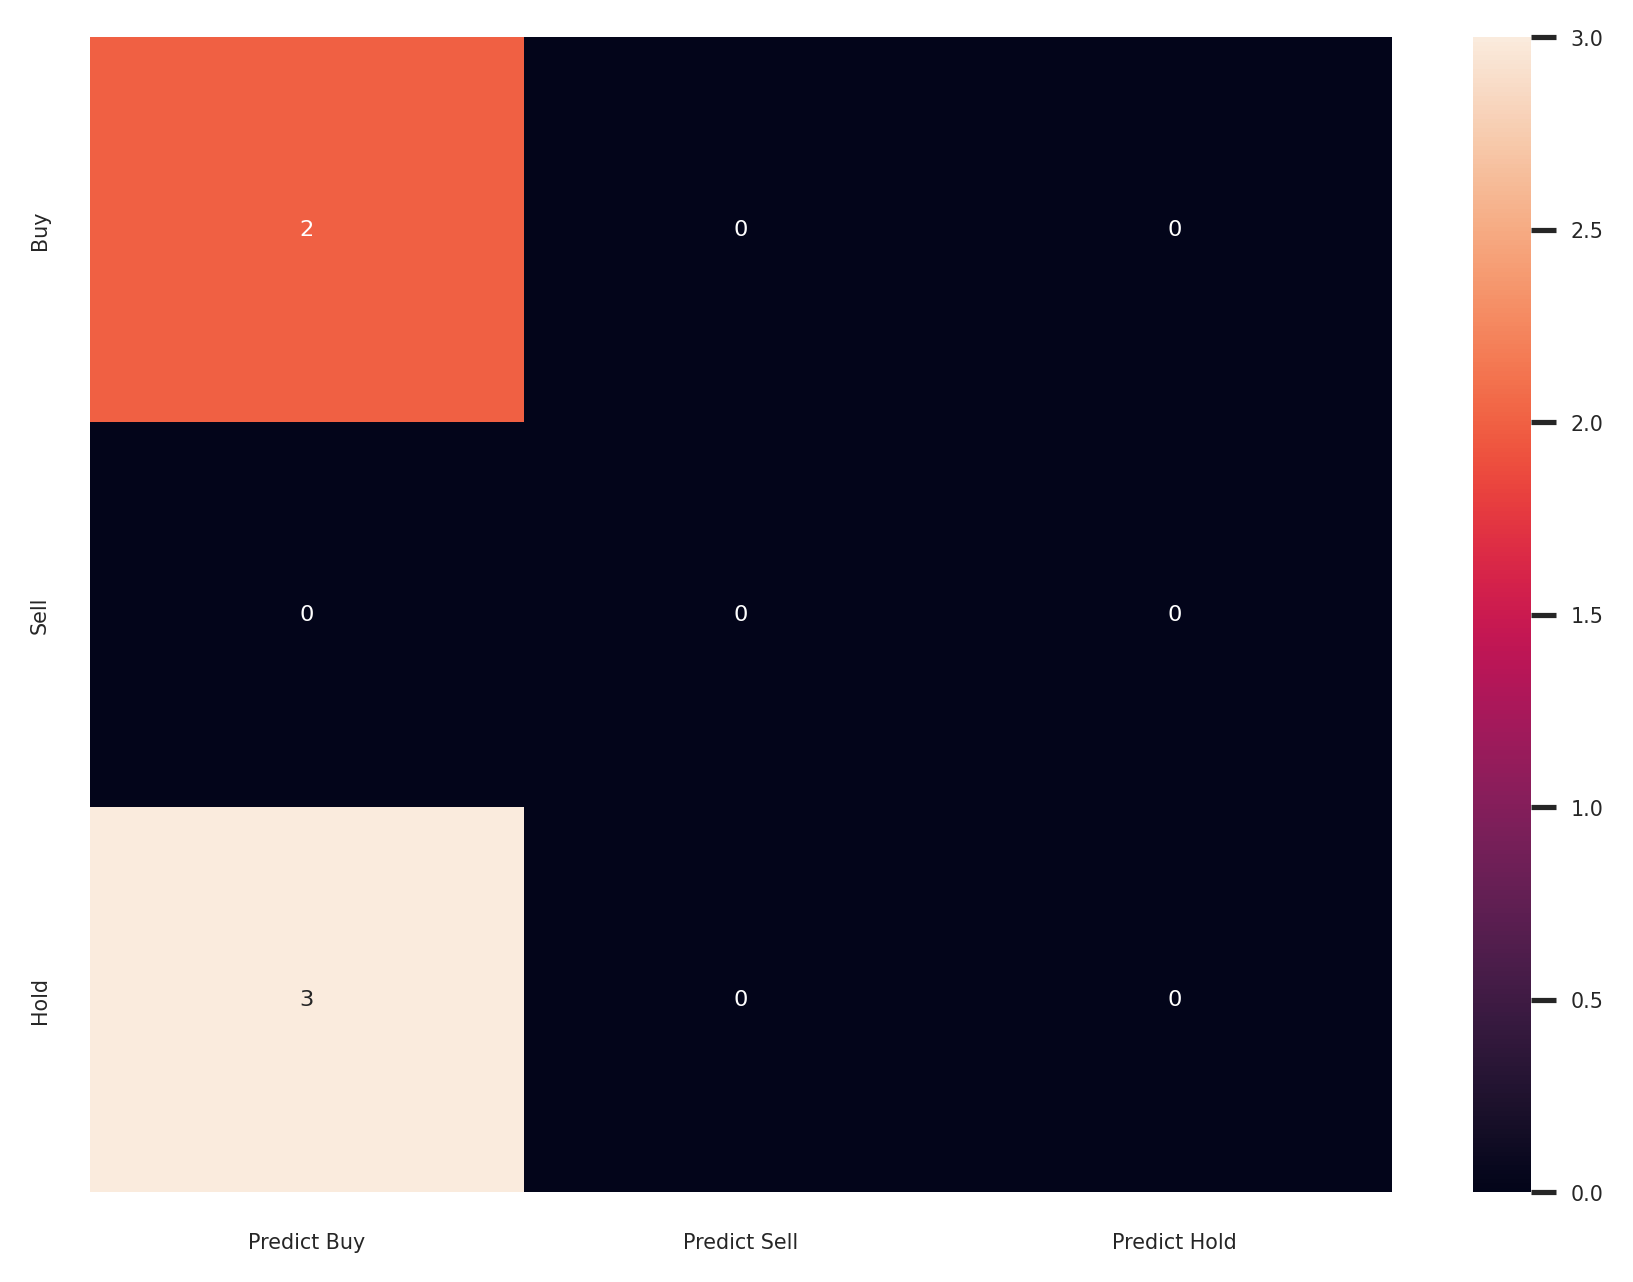

In [ ]:
# Confusion Matrix of GaussianNB

cm = metrics.confusion_matrix(y_test, y_pred_gnb, labels=[1,0,2])

df_cm = pd.DataFrame(cm, index = [i for i in ["Buy","Sell","Hold"]],
                         columns = [i for i in ["Predict Buy", "Predict Sell","Predict Hold"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
# Find Performance of GaussianNB

y_pred_proba = gnb.predict(X_test)
gnb_performance = accuracy_score(y_test, y_pred_proba)
gnb_performance

0.4

In [ ]:
# Comparision of all Models

def comp_model(model_list, model_train_acc_list, model_test_acc_list, model_performance_list):
    data = {"Model Name": model_list, "Train Accuracy(%)": [i*100 for i in model_train_acc_list], "Test Accuracy(%)": [i*100 for i in model_test_acc_list], "Performance Score": model_performance_list}
    Comparision = pd.DataFrame(data)
    return Comparision

In [ ]:
model_list = ["Decision Tree Classifier", "SVM", "KNN","GaussianNB"]
model_train_acc_list = [dt_train_acc, svm_train_acc, knn_train_acc, gnb_train_acc]
model_test_acc_list = [dt_tacc, svm_tacc, knn_tacc, gnb_tacc]
model_performance_list = [dt_performance, svm_performance, knn_performance, gnb_performance]
comp_model(model_list, model_train_acc_list, model_test_acc_list, model_performance_list)

,Model Name,Train Accuracy(%),Test Accuracy(%),Performance Score
0,Decision Tree Classifier,100.000000,60.0,0.6
1,SVM,100.000000,60.0,0.6
2,KNN,100.000000,80.0,0.8
3,GaussianNB,86.111111,40.0,0.4


In [ ]:
# Get the data of one stock from yahoo api

sample_stock = "GOOGL"
yahoo_financials_sample = YahooFinancials([sample_stock])

price_to_earnings = [yahoo_financials_sample.get_pe_ratio()[sample_stock]] # Price to Earnings
debt_to_equity = [yahoo_financials_sample.get_financial_data()[sample_stock].get('debtToEquity', None)] # Debt to Equity
book_value_per_share = [yahoo_financials_sample.get_key_statistics_data()[sample_stock].get('bookValue', None)] # Book Value Per Share
price_to_book_value = [yahoo_financials_sample.get_key_statistics_data()[sample_stock].get('priceToBook', None)] # Price to Book Value
fifty_two_week_high = [yahoo_financials_sample.get_yearly_high()[sample_stock]]
fifty_two_week_low = [yahoo_financials_sample.get_yearly_low()[sample_stock]]
fifty_day_moving_avg = [yahoo_financials_sample.get_50day_moving_avg()[sample_stock]]
two_hunderd_day_moving_avg = [yahoo_financials_sample.get_200day_moving_avg()[sample_stock]]
recommendation = [yahoo_financials_sample.get_financial_data()[sample_stock].get('recommendationKey', None)] # Recommendation

sentiment_dict = {'positive': 1, 'negative': 0, 'neutral': 2}
sentiment = [sentiment_dict.get(find_sentiment(sample_stock))]
recommendation

['buy']

In [ ]:
data1 = price_to_earnings+debt_to_equity+book_value_per_share+price_to_book_value+fifty_two_week_high+fifty_two_week_low+fifty_day_moving_avg+two_hunderd_day_moving_avg+sentiment
data1

[23.895784, 11.305, 20.507, 5.2552786, 122.43, 83.34, 101.2228, 100.4711, 1]

In [ ]:
#input data and transform into numpy array
in_data= np.asarray(data1)
#reshape and scale the input array
in_data_re = in_data.reshape(1,-1)
in_data_sca = scaler.transform(in_data_re)

ans = knn.predict(in_data_sca)
#print the predicted output for input array
if ans == 1:
  print("Buy")
elif ans == 0:
   print("Sell")
else :
   print("Hold")


Buy
